<hr style="border:2px solid black"> </hr>

# <center><font size="7">Nootropics</font></center>

<center><font size="4">Welcome to the wonderful world of nootropics, where no task is ever too demanding!</font></center>

<hr style="border:2px solid black"> </hr>

# A. How to use this notebook

This notebook is a part of a [project (MAKE SURE LINK WORKS)](https://XXXXXXXXXXXX). To gain access to all the functionality, download the project and run the notebook from the project root.

## A.1 The code


The code presented in this notebook has been boiled down to as few function calls as possible to make it easy for the reader to play with the parameters we have been tweaking during data collection and analysis. 

The all the underlying code written by the the authors of this notebook has been organized in two packages residing in the project root:

* `library_functions`
* `wojciech`

The project also requires following external packages:

```
plotly, version 4.12.0
pandas, version 1.1.1
spacy, version 2.3.2
infomap, version 1.2.1
regex, version 2020.7.14
ipywidgets, version 7.5.1
tqdm, version 4.50.0
python_louvain, version 0.14
wikipedia, version 1.4.0
textblob, version 0.15.3
fa2, version 0.3.5
numpy, version 1.19.2
wordcloud, version 1.8.0
networkx, version 2.5
matplotlib, version 3.3.2
powerlaw, version 1.4.6
beautifulsoup4, version 4.9.3
community, version 1.0.0b1
ipython, version 7.19.0
mediawiki, version 0.0.1
project, version 20
psaw, version 0.0.12
```

Additionally, we will need the `en_core_web_sm` language module  for the `spaCy` package. It can downloaded by running the cell:

In [1]:
# !python -m spacy download en_core_web_sm

## A.2 The data [UPDATE!]

The *raw* data is placed in the folder:

 `wikipedia_data`

 The cleaned data is placed in the folder:

 `shared_data`

# B. Initialization

All necessary imports and definitions can be effectuated by running the cell:

In [2]:
from library_functions.initialize_explainer_notebook import *

<hr style="border:2px solid black"> </hr>

# 1. Motivation

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

<hr style="border:2px solid black"> </hr>

# 2. Basic stats

There were five main parts in obtaining and preparing our data:

1. Obtaining a list of the WikiPedia pages we want to use
2. Downloading those pages and extracting links between them
3. Downloading all reddit posts from [r/nootropics](https://www.reddit.com/r/Nootropics/)
4. Finding mentions of nootropics in those posts
5. Assigning sentiments to Reddit Posts

## 2.1 Data Collection and Cleaning

### 2.1.1 WikiPedia: Choosing which pages to download

To start off, we needed to choose which WikiPedia data to use. Initially, we took all the pages that were below the category [Drugs by psychological effects](https://en.wikipedia.org/wiki/Category:Drugs_by_psychological_effects), and manually removed irrelevant pages and sub-categories. We mainly removed:

- Everything under categories that cannot realistically be considered nootropics, such as [Psychedelic Drugs](https://en.wikipedia.org/wiki/Category:Psychedelic_drugs)
- Pages and categories that were not about specific substances - such as [Songs about Tobacco](https://en.wikipedia.org/wiki/Category:Songs_about_tobacco)
- Pages about __types__ of substances - such as [Stimulant](https://en.wikipedia.org/wiki/Stimulant). We only want to include substances - not *types of substances*.

This part was very tedious and manual, and there was really nothing interesting about it - so we won't include code here. If you are interested, notes are in [TODO - LINK NOTEBOOK], You can also look at the resulting category tree [here](https://github.com/wojciechdk/Social_Graphs_and_Interactions_Final_Project/blob/master/shared_data/full_category_tree_clean.json).

### 2.1.2 WikiPedia: Downloading the pages and extracting links

Now that we had our list of pages, we needed to actually download them. This was more challenging than expected, and resulted in a couple of pull requests to the python library we are using. We won't go into details here are it is mostly irrelevant for our later analysis, but you're invited to look in [TODO-add link] for more information.

Briefly, that notebook does three things:

1. Traverse the category tree we generated before
2. Download each page and save it to file
3. Extract links (the hard part to get right)

The result is a large amount of files (~1500) with the contents of all the pages (which are not included in our repo to save space), as well as one large file containing the resulting data in a more convenient form - which you can find [here](https://github.com/wojciechdk/Social_Graphs_and_Interactions_Final_Project/blob/master/shared_data/full_wiki_data.json).

### 2.1.3 Reddit: Downloading Posts

For Reddit posts, we make use of the [Pushift Python Library](https://github.com/pushshift/api), which is an interface to the [Pushift.io](https://api.pushshift.io/). This library is very powerful and easy to use, which meant that downloading over a 100.000 posts took much less effor than the 1.500 pages on wikipedia. Once more, the details aren't really relevant to this course - so we won't show them here, but feel free to look at [TODO - insert link].

## 2.2 Data preprocessing [Luca & Wojciech]

* Detection of matches in content,
* Sentiment analysis with TextBlob

## 2.3 Data statistics

* Wiki: number of pages,
* Reddit: number of posts,
* Data size in bytes.
* Histograms: matches per post, reddit post length, etc..

<hr style="border:2px solid black"> </hr>

# 3. Tools, theory and analysis. Describe the process of theory to insight

* Talk about how you've worked with text, including regular expressions, unicode, etc.

* Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

* How did you use the tools to understand your dataset?

## 3.1 General idea?
Explain the overall idea


## 3.2 Graph creation

We will be modelling the Wikipedia graph as a directional graph, and the Reddit graph as an undirectional graph. For easier comparison of the graphs we have decided to use the __names of substances regarded as nootropics on Wikipedia__ as nodes for both the Wikipedia and the Reddit network.

### 3.2.1 Wikipedia

#### 3.2.1.1 Nodes

The __*nodes*__ in the Wikipedia network will have the following attributes:

* `categories`: a list of categories to which the substance belongs on Wikipedia, e.g. `stimulant`.

* `content`: the clean content of the substance's Wikipedia page.

* `url`: the url of the substance's Wikipedia page.

#### 3.1.1.2 Edges

The __*edges*__ in the Wikipedia network will have the following attributes:

* `count`: Number of occurrences of the edge (sometimes a link appears multiple times in the same page).

#### 3.1.1.3 Code for graph creation

To create the Wikipedia graph, run the cell:

In [3]:
g_wiki = lf.create_graph_wiki()

### 3.2.2 Reddit

#### 3.2.2.1 Nodes

We have already mentioned that we have chosen that **_nodes_** of the Reddit graph be the same as the nodes of the Wikipedia graph. Their attributes, however, are different:

* `categories`: a list of categories to which the substance belongs on Wikipedia, e.g. `stimulant`.

* `count`: The number of Reddit posts in which the substance is mentioned.

* `polarity`: a list where each element represents a measure of positivity of sentiment of a post in which the substance is mentioned. The polarity ranges from -1 to 1, where -1 represents a completely negative sentiment, and +1 completely positive sentiment.

* `subjectivity`: a list where each element represents a measure of subjectivity of a post in which the substance is mentioned. The subjectivity ranges from 0 to 1, where 0 represents a completely factual post, and 1 completely subjective opinion.

* `content` (optional): a list where each element represents contents (text) of a post in which the substance is mentioned.

#### 3.2.2.2 Edges

The __*edges*__ of the Reddit network will have following attributes:

* `count`: The number of Reddit posts in which the linked substances are mentioned.

* `number_of_drugs_in_post`: a lit where each element represents the number of substances mentioned in the Reddit post in which the linked substances occur.

* `polarity`: a list where each element represents a measure of positivity of sentiment of a post in which the substance is mentioned. The polarity ranges from -1 to 1, where -1 represents a completely negative sentiment, and +1 completely positive sentiment.

* `subjectivity`: a list where each element represents a measure of subjectivity of a post in which the substance is mentioned. The subjectivity ranges from 0 to 1, where 0 represents a completely factual post, and 1 completely subjective opinion.

* `content` (optional): a list where each element represents contents (text) of a post in which the substance is mentioned.

#### 3.2.2.3 Tweakable parameters

The graph is created using the function `lf.create_graph_reddit`. In the input of this function, the user can specify a number of constraints that will affect the creation of the graph. The tweakable parameters are:

* `max_drugs_in_post`: a maximum accepted drugs in a post. The Reddit posts containing more drugs will be disregarded. This parameter can be used to filter out posts containing entire lists of drugs, and thus do not reveal much useful information about a possible connection between specific substances.

* `min_edge_occurrences_to_link`: a limit describing the minimum number times a link needs to appear in order to be considered valid. The links that occur less times will be disregarded. This parameter can be used to filter out seldom occurring links.

* `min_content_length_in_characters`: a limit describing the minimum allowabgle length of the content of the Reddit post. Posts with shorter content will be disregarded. This parameter can be used to filter out posts with very short content.

* `conditional_functions_dict`: a dictionary keyed by attribute names whose values are functions that represent conditions for those attributes, e.g.:

 ```
 conditions = {'polarity': lambda x: x > 0.1,
               'subjectivity': lambda x: < 0.2}
 ```
 
 This parameter can be used to create a graph based on the values of a certain attribute, or a combination of attributes, e.g. a graph of substances connected in posts with a positive sentiment.

* `include_node_contents`: A boolean determining whether to assign the content of the posts containing a drug as a node attribute. This parameter can be used to reduce the amount of data stored in RAM and shorten up the processing time.

* `include_link_contents`: A boolean determining whether to assign the content of the posts containing a drug as a edge attribute. This parameter can be used to reduce the amount of data stored in RAM and shorten up the processing time

#### 3.2.2.3 Effect of tweakable parameters on the Reddit graph

In this section we will present our reasoning behind our choice of values for the parameters that affect the formation of the Reddit graph. To do this we will compare four Reddit graphs created using the constraints we will be using in the remainder of the project:

* A raw graph, created with no constraints.
* A graph where Reddit posts with more than 10 substances were discarded.
* A graph where Reddit posts whose content was less than 25 characters log where discarded.
* A graph where all the links appearing less then 2 times were removed.

The graphs are created by running the cell:

In [4]:
# Create test Reddit graphs.
test_reddit_graphs = dict()

test_reddit_graphs['Raw'] = lf.create_graph_reddit()

test_reddit_graphs['Max 10 drugs in post'] = \
    lf.create_graph_reddit(max_drugs_in_post=10)

test_reddit_graphs['Min 25 characters in post'] = \
    lf.create_graph_reddit(min_content_length_in_characters=25)

test_reddit_graphs['Min 3 occurences to link'] = \
    lf.create_graph_reddit(min_edge_occurrences_to_link=3)

Let's first take a look at the distribution of the edge attribute: __*polarity_weighted*__, which is a one-digit representation of the positivity of the sentiment of all posts in which the edge exists.

We can plot the comparison of the networks created using different parameters by running the cell:

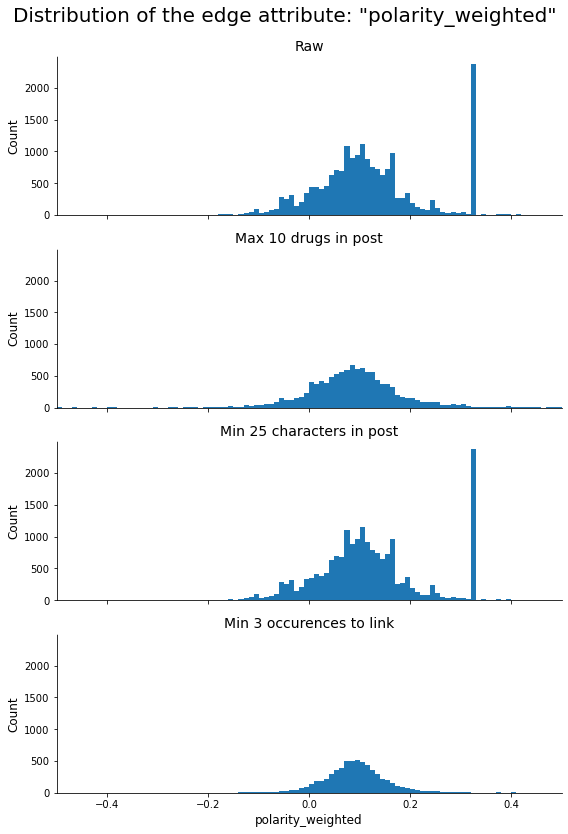

In [5]:
# Plot the distribution of the edge parameter: "polarity_weighted"
axess = w.graph.plot_comparison_of_attribute_distributions(
    test_reddit_graphs,
    attribute_name="polarity_weighted",
    attribute_parent="edge",
    as_probability_distribution=False,
    bins=np.linspace(-1, 1, 201),
    x_limit=(-0.5, 0.5),
    fig_width=8
)

We can see in the figure above that the raw graph (top plot) contains a very high number of edges with weighted polarity value of around 3.5. An investigation showed that this has been caused by a small fracture of posts containing long lists of substances, often for commercial purposes. Without any constraints, we would create a link between all the substances present in such a post. We are, however, more interested in the links between substances that the Reddit users discuss rather than posts that serve as advertisements. Therefore, we have decided to impose a limit of max 10 substantes per post that will be included in our graph (second plot from top).

We have also chosen to disregard the very weak links i.e. links that appear less then 3 times, in order to reduce the amound of "noise" in the created graph (bottom plot). 

To understand why we have chosen to disregard the Reddit posts whose content was less than 25 characters long, let's look at the distrbution of the polarity values for a popular nootropic substance: caffeine:

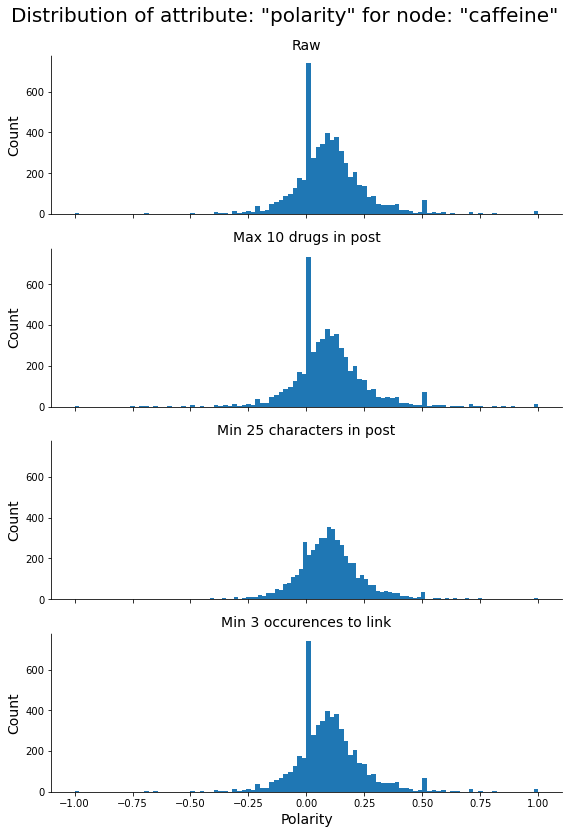

In [6]:
# Plot distribution of values of one instance (node or edge)
axess = w.graph.plot_distribution_of_attribute_of_1_instance(
    test_reddit_graphs,
    instance="node",
    instance_label="caffeine",
    attribute_name="polarity",
    fig_width=8
)

We can see in the figure above that the raw graph contains exceptionally many posts containing caffeine with a polarity of 0. An investigation of this phenomenon revealed that the word "coffeine" was mentioned in the title of a removed post, whose content therefore consisted of a single string: `[removed]`. As such posts provide with with little to none information about the context of a potential link, we have chosen to disregard posts with less than 25 characters. 

#### 3.2.2.4 Code for graph creation

To create the Reddit graph with our choice of constraints, run the following code:

In [7]:
g_reddit = lf.create_graph_reddit(
    max_drugs_in_post=10,
    min_edge_occurrences_to_link=3,
    min_content_length_in_characters=25,
    conditional_functions_dict=None,
    include_node_contents=False,
    include_link_contents=False,
    show_progress_bars=False
)

We also invite the reader to create an alternative graph using their own constraints. We will include this graph in our analysis in the following chapters:

In [8]:
g_reddit_reader = lf.create_graph_reddit(
    max_drugs_in_post=10,
    min_edge_occurrences_to_link=3,
    min_content_length_in_characters=25,
    conditional_functions_dict={'polarity': lambda x: x > 0.15},
    include_node_contents=False,
    include_link_contents=False,
    show_progress_bars=False
)

## 3.3 Network evaluation

In this chapter we will zoom in on specific properties of the created networks, compare them, and interpret our findings.

Let's start by organizing the graphs we will be comparing in a dict:

In [9]:
# List the graphs that will be used in further analysis.
graphs = {'Wikipedia': g_wiki,
          'Reddit': g_reddit,
          'Reddit (reader)': g_reddit_reader}

### 3.X.X Basic degree statistics

In [10]:
# Display the basic degree statistics.
for graph_name, graph in graphs.items():
    printmd(f'Degree statistiscs for the **{graph_name}** network:')
    degree_stats_reddit = w.graph.degree_statistics(graph,
                                                    as_pandas=True,
                                                    printout=True)
    print()

Degree statistiscs for the **Wikipedia** network:

,Min,Max,Mean,Median,Mode
Total degree,0,115,5.55526,2.0,0
In-degree,0,86,2.77763,1.0,0
Out-degree,0,40,2.77763,1.0,0


Degree statistiscs for the **Reddit** network:

,Min,Max,Mean,Median,Mode
Total degree,0,201,5.60719,0.0,0


Degree statistiscs for the **Reddit (reader)** network:

,Min,Max,Mean,Median,Mode
Total degree,0,102,2.209055,0.0,0


**WRITE INTERPRETATION HERE**

### 3.3.1 Degree distribution

We can compare the degree distributions of our networks by running the cell:

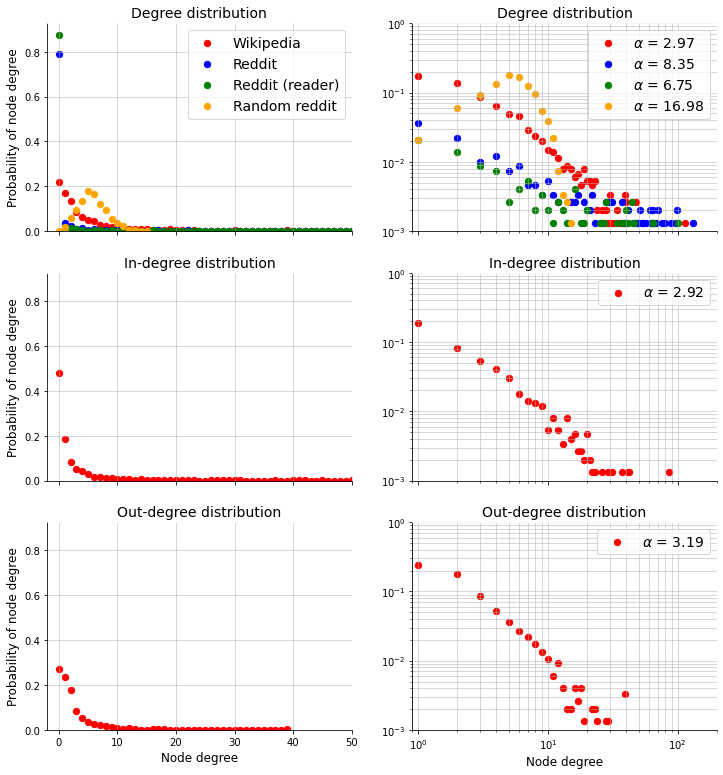

In [11]:
# Create a random network with the same degree probability as the g_reddit network.
random_like_g_reddit = w.graph.erdos_renyi_like(g_reddit)

# Add the created random network to the collection of graphs to analyze.
graphs_to_analyze = graphs.copy()
graphs_to_analyze.update({'Random reddit': random_like_g_reddit})

# Define the colors by which the graphs will be represented in the analysis.
graph_colors = ["red", "blue", "green", "orange"]

# Plot the comparison of the degree distribution.
all_axes = w.graph.plot_degree_distribution_summary(
    graphs_to_analyze,
    graph_colors=graph_colors,
    x_lim_lin=(-2, 50),
    x_lim_log=(0.9, 200)
)

We can see in the figure above that both the Wikipedia and the Reddit networks have highly connected nodes, and that variance of the degrees of their nodes is much higher that the variance of a comparable random network. However, only the Wikipedia network exhibits the scale-free property with $\alpha$ just under 3.

### 3.3.2 Most central nodes

In this chapter we will discover the most central nodes in our networks. Let's start by defining some parameters about how we we want our results presented:

In [12]:
# Define the number of nodes to show in the result tables
n_results = 5

# Specify the precision for the digits in the result tables
precision_in_decimals = 3 

# Define the precision of of the displayed numbers
pd.options.display.float_format = f"{{:,.{precision_in_decimals}f}}".format

Now, we can get the information about the most central nodes by running the cell:

In [13]:
# Show the most central nodes
for graph_name, graph in graphs.items():
    printmd(f'The most central nodes in the **{graph_name}** network:')
    most_central_nodes_wiki = w.graph.most_central_nodes(
        graph, n=n_results, as_pandas=True, printout=True)
    print()

The most central nodes in the **Wikipedia** network:

Degree                       In-degree        \
                       Drug Score                      Drug Score   
1  tricyclic antidepressant   115               amphetamine    86   
2               amphetamine   114                   cocaine    85   
3               barbiturate   107               barbiturate    84   
4                   cocaine   103  tricyclic antidepressant    76   
5           methamphetamine    75                      mdma    56   

                 Out-degree            Betweenness        \
                       Drug Score             Drug Score   
1                    rti-56    40      amphetamine 0.043   
2                   rti-331    40          cocaine 0.039   
3                   rti-332    40  methamphetamine 0.035   
4                   rti-333    40      barbiturate 0.030   
5  tricyclic antidepressant    39         nicotine 0.027   

                Eigenvector        
                       Drug Score  
1  tricyclic antidepressant 0.334  
2                imipramine 0.253  
3                fluoxetine 0.229  
4             amitriptyline 0.221  
5              clomipramine 0.206

The most central nodes in the **Reddit** network:

Degree                  Betweenness        \
                    Drug Score                   Drug Score   
1  s-adenosyl methionine   201  s-adenosyl methionine 0.009   
2               caffeine   173               caffeine 0.005   
3               theanine   159                    tea 0.003   
4                 coffee   143               theanine 0.002   
5                choline   136                 coffee 0.002   

             Eigenvector        
                    Drug Score  
1  s-adenosyl methionine 0.158  
2               caffeine 0.154  
3               theanine 0.153  
4                 coffee 0.147  
5                choline 0.147

The most central nodes in the **Reddit (reader)** network:

Degree                  Betweenness  \
                                         Drug Score                   Drug   
1                                    caffeine   102               caffeine   
2                                    theanine   102  s-adenosyl methionine   
3                       s-adenosyl methionine    99               theanine   
4                                     choline    81                choline   
5  n-phenylacetyl-l-prolylglycine ethyl ester    79              modafinil   

                                        Eigenvector        
  Score                                        Drug Score  
1 0.002                                    caffeine 0.199  
2 0.002                                    theanine 0.198  
3 0.002                       s-adenosyl methionine 0.194  
4 0.001                                     choline 0.184  
5 0.001  n-phenylacetyl-l-prolylglycine ethyl ester 0.182

**INTERPRETATION HERE**

### 3.3.3 Most often occurring edges

In this chapter we will discover the most central nodes in our networks. Let's start by defining some parameters about how we we want our results presented:

In [14]:
lf.most_frequent_edges(graphs,
                       n=5,
                       as_pandas=True,
                       printout=True)

,graph_name
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000


{'graph_name': [(('caffeine', 'theanine'), 778),
  (('caffeine', 'coffee'), 371),
  (('theanine', 'coffee'), 261),
  (('citicoline', 'choline'), 199),
  (('caffeine', 's-adenosyl methionine'), 181)]}

<hr style="border:2px solid black"> </hr>

# 4. Discussion

* What went well?,
* What is still missing? What could be improved?, Why?

<hr style="border:2px solid black"> </hr>

# 5. Contributions

* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).
